# K-Fold_Cross_Validation
* https://www.youtube.com/watch?v=Q8ZQNvZwsNE&list=PLjy4p-07OYzuy_lHcRW8lPTLPTTOmUpmi&index=17
* https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_04_1_kfold.ipynb

### * check machine

In [1]:
import copy
import torch

try:
    import google.colab
    COLAB = True
    print("Note: using Google Colab")
except:
    COLAB = False
    print("Note: not using Google Colab")

# Make use of a GPU or MPS(Apple) if one is available.
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Note: using Google Colab
Using cpu device


## * define Early Stopping Class

In [18]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_bset_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs"
                if self.restore_bset_weights:
                    model.load_state_dict(self.best_model)
                    return True
        return False

# K-Fold Cross Validation
You can use cross-validation for a variety of purpose in predictive modeling:
* Generating out-of-sample predictions from a neural network
* Estimate a good number of epochs to train a neural network for (early stopping)
* Evaluate the effectiveness of certain hyperparameters, such as activation functions, neuron counts, and layer counts


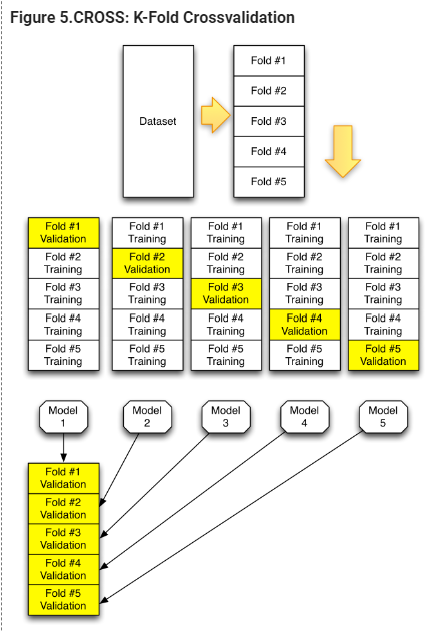

In [4]:
from PIL import Image

im = Image.open('/content/drive/MyDrive/study_DeepLearning/pytorch_youtube/k_fold.png')
im

It is important to note that each fold will have one model (neural network). To generate predictions for new data (not present in the training set), predictions from the fold models can be handled in several ways:
* Choose the model with the highest validation score as the final model.
* Preset new data to the five models (one for each fold) and average the result (this is an **ensumble**).
* Retain a new model (using the same settings as the cross-validation) on the entire dataset. Train for as many epochs and with the same hidden layer structure.


## Regression vs Classification K-Fold Cross-Validation
Regression and classification are handled somewhat differently concerning cross-validation. Regression is the simpler case where you can break up the data set into K folds with little regard for where cach item lands. Fore regression, the data items should fall into <u>the folds as rendomly as possible</u>. It is not always possible for the data set to be evenly divided into K folds. For regression cross-validation, we will use the Scikit-Learn class **KFold**.


Cross-validation for classification could also use the **KFold** object; however, this techinique would not ensure that the class balance remains the same in each fold as in the original. <u>The balance of classes that a model was trained on must remain the same (or similar) to the trining set</u>. Drift in this distribution is one of the most important things to monitor after a trained model has been placed into actual use. Because of this, we want to make sure that the cross-validation itself does not introduce an unintended shift. This technique is called stratified sampling and is accomplished by using the Scikit-Learn object **StratifiedKFold** in place of **KFold** whenever you use classification. In summary, you should use the following two objects in Scikit-Learn:
* **KFold** When dealing with a regression problem.
* **StratifiedKFold** When dealing with a classification problem.

# Out-of-Sample Regressin Predictioons with K-Fold Cross-Validation
The following code trains the simple dataset using a 5-fold cross-validation. The expected performance of a neural network of the type trained here would be the score for the generated out-of-sample predictions. We begin by preparing a feature vector using the jh-simple-dataset to predict age. This model is set up as a regression problem.

In [5]:
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?']
)

# Generate dummies for job
df = pd.concat([df, pd.get_dummies(df['job'], prefix="job", dtype=int)], axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df, pd.get_dummies(df['area'], prefix="marital", dtype=int)], axis=1)
df.drop('area', axis=1, inplace=True)

# Generate dummies for product
df = pd.concat([df, pd.get_dummies(df['product'], prefix="product", dtype=int)], axis=1)
df.drop('product', axis=1, inplace=True)

# Missing values for incom
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['subscriptions'] = zscore(df['subscriptions'])

In [6]:
df.head()

,id,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,...,marital_b,marital_c,marital_d,product_a,product_b,product_c,product_d,product_e,product_f,product_g
0,1,-0.607550,-0.664918,-0.208449,9.017895,-0.215764,11.738935,49,0.885827,0.492126,...,0,1,0,0,1,0,0,0,0,0
1,2,0.338053,-0.207748,0.839031,7.766643,0.196869,6.805396,51,0.874016,0.342520,...,0,1,0,0,0,1,0,0,0,0
2,3,-0.184205,1.127906,-0.208449,3.632069,-0.714362,13.671772,44,0.944882,0.724409,...,0,1,0,0,1,0,0,0,0,0
3,4,-0.526467,-0.440815,-0.208449,5.372942,-0.542432,4.333286,50,0.889764,0.444882,...,0,1,0,0,1,0,0,0,0,0
4,5,-2.851675,1.638861,1.886511,3.822477,-0.473660,5.967121,38,0.744094,0.661417,...,0,0,1,1,0,0,0,0,0,0


Now that the feature vector is created a 5-fold cross-validation can be performed to generate out-of-sample predictions. We will assume 500 epochs and not use early stopping. Later we will see how we can estimate a more optimal epoch count.

In [7]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [8]:
# Convert to PyTorch tensors
x_columns = df.columns.drop(['age', 'id'])
x = torch.tensor(df[x_columns].values, dtype=torch.float32, device=device)
y = torch.tensor(df['age'].values, dtype=torch.float32, device=device)

# Set random seed for reproducibility
torch.manual_seed(42)

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Early stopping parameters
patience = 10

fold = 0
for train_idx, test_idx in kf.split(x):
    fold += 1
    print(f"Fold #{fold}")

    # Split into training and test sets
    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # PyTorch DataLoader
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Create the model and optimizer
    model = nn.Sequential(
        nn.Linear(x.shape[1], 20),
        nn.ReLU(),
        nn.Linear(20, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    model = torch.compile(model, backend="aot_eager").to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # Early Stopping variables
    best_loss = float('inf')
    early_stopping_counter = 0

    # Trining loop
    EPOCHS = 500
    epoch = 0
    done = False
    es = EarlyStopping()

    while not done and epoch < EPOCHS:
        epoch += 1
        model.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_output = model(x_test)
            val_loss = loss_fn(val_output, y_test)

        # Early stopping
        if es(model, val_loss):
            done = True

    print(f"Epoch {epoch}/{EPOCHS}, Validation Loss: {val_loss.item()}, {es.status}")

# Final evaluation
model.eval()
with torch.no_grad():
    oos_pred = model(x_test)
score = torch.sqrt(loss_fn(oos_pred, y_test)).item()
print(f"Fold score (RMSE): {score}")

Fold #1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([400])) that is different to the input size (torch.Size([400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

Epoch 106/500, Validation Loss: 14.6895112991333, Early stopping triggered after 5 epochs
Fold #2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([400])) that is different to the input size (torch.Size([400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

Epoch 91/500, Validation Loss: 15.774996757507324, Early stopping triggered after 5 epochs
Fold #3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([400])) that is different to the input size (torch.Size([400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

Epoch 71/500, Validation Loss: 14.606364250183105, Early stopping triggered after 5 epochs
Fold #4


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([400])) that is different to the input size (torch.Size([400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

Epoch 68/500, Validation Loss: 14.834468841552734, Early stopping triggered after 5 epochs
Fold #5


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[2024-05-02 08:27:12,871] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (8)
[2024-05-02 08:27:12,871] torch._dynamo.convert_frame: [WARNING]    function: 'inner' (/usr/local/lib/python3.10/dist-packages/torch/_dynamo/external_utils.py:15)
[2024-05-02 08:27:12,871] torch._dynamo.convert_frame: [WARNING]    last reason: ___guarded_code.valid
[2024-05-02 08:27:12,871] torch._dynamo.convert_frame: [WARNING] To log all recompilation reasons, use TORCH_LOGS="recompiles".
[2024-05-02 08:27:12,871] torch._dynamo.convert_frame: [WARNING] To diagnose recompilation issues, see https://pytorch.org/docs/master/compile/trouble

Epoch 66/500, Validation Loss: 13.269009590148926, Early stopping triggered after 5 epochs
Fold score (RMSE): 3.6361289024353027


As you can see, the above code also reports the average number of epochs needed. A common technique is to then train on the entire dataset for the average number of epochs required.

# Classification with Stratified K-Fold Cross-Validation
The following code trains and fits the jh-simple-dataset dataset with cross-validation to generate out-of-sample. It also writes the out-of-sample (predictions on the test set) results.

It is good to perform stratified k-fold cross-validation with classification data. This technique ensures that the percentages of each class remain the same across all folds. Use the **StratifiedKFold** object instead of the KFold object used in the regression.

In [9]:
# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=["NA", "?"],
)

# Generate dummies for job
df = pd.concat([df, pd.get_dummies(df["job"], prefix="job",dtype=int)], axis=1)
df.drop("job", axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df, pd.get_dummies(df["area"], prefix="area",dtype=int)], axis=1)
df.drop("area", axis=1, inplace=True)

# Missing values for income
med = df["income"].median()
df["income"] = df["income"].fillna(med)

# Standardize ranges
df["income"] = zscore(df["income"])
df["aspect"] = zscore(df["aspect"])
df["save_rate"] = zscore(df["save_rate"])
df["age"] = zscore(df["age"])
df["subscriptions"] = zscore(df["subscriptions"])

# Convert to numpy - Classification
x_columns = df.columns.drop("product").drop("id")
x = df[x_columns].values
dummies = pd.get_dummies(df["product"],dtype=int)  # Classification
products = dummies.columns
y = dummies.values

df.head()

,id,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,...,job_qp,job_qw,job_rn,job_sa,job_vv,job_zz,area_a,area_b,area_c,area_d
0,1,-0.607550,-0.664918,-0.208449,9.017895,-0.215764,11.738935,0.854321,0.885827,0.492126,...,0,0,0,0,1,0,0,0,1,0
1,2,0.338053,-0.207748,0.839031,7.766643,0.196869,6.805396,1.394432,0.874016,0.342520,...,0,0,0,0,0,0,0,0,1,0
2,3,-0.184205,1.127906,-0.208449,3.632069,-0.714362,13.671772,-0.495957,0.944882,0.724409,...,0,0,0,0,0,0,0,0,1,0
3,4,-0.526467,-0.440815,-0.208449,5.372942,-0.542432,4.333286,1.124377,0.889764,0.444882,...,0,0,0,0,0,0,0,0,1,0
4,5,-2.851675,1.638861,1.886511,3.822477,-0.473660,5.967121,-2.116291,0.744094,0.661417,...,0,0,0,0,0,0,0,0,0,1


In [14]:
print(x.shape)
print(y.shape)

(2000, 47)
(2000, 7)


In [19]:
import numpy as np
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

# Assuming your data is in Numpy Arrays. If not, convert them into Numpy Arrays
x = np.array(x)
y = np.array(y)

# Use the nn.Sequential API
model = nn.Sequential(
    nn.Linear(x.shape[1], 50),
    nn.ReLU(),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Linear(25, y.shape[1]),
    nn.Softmax(dim=1),
)
model = torch.compile(model,backend="aot_eager").to(device)

# Cross-validate
kf = StratifiedKFold(5, shuffle=True, random_state=42)

# Defining Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

oos_y = []
oos_pred = []
fold = 0

for train, test in kf.split(x, df["product"]):
    fold += 1
    print(f"Fold #{fold}")

    x_train = torch.tensor(x[train], device=device, dtype=torch.float32)
    y_train = torch.tensor(np.argmax(y[train], axis=1),device=device, dtype=torch.long)  # Convert to class indices
    x_test = torch.tensor(x[test],device=device, dtype=torch.float32)
    y_test = torch.tensor(np.argmax(y[test], axis=1),device=device, dtype=torch.long)  # Convert to class indices

    # Training loop
    EPOCHS = 500
    epoch = 0
    done = False
    es = EarlyStopping(restore_best_weights=True)

    while not done and epoch < EPOCHS:
        epoch += 1
        model.train()
        optimizer.zero_grad()
        output = model(x_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        # Evaluate validation loss
        model.eval()
        with torch.no_grad():
            y_val = model(x_test)
            val_loss = criterion(y_val, y_test)

        if es(model, val_loss):
            done = True

    # Prediction
    with torch.no_grad():
        y_val = model(x_test)
        _, pred = torch.max(y_val, 1)

    oos_y.append(y_test.cpu().numpy())
    oos_pred.append(pred.cpu().numpy())

    print(
        f"Epoch {epoch}/{EPOCHS}, Validation Loss: " f"{val_loss.item()}, {es.status}"
    )

    # Measure this fold's accuracy
    score = metrics.accuracy_score(y_test.cpu().numpy(), pred.cpu().numpy())
    print(f"Fold score (accuracy): {score}")

# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

score = metrics.accuracy_score(oos_y, oos_pred)
print(f"Final score (accuracy): {score}")

Fold #1
Epoch 360/500, Validation Loss: 1.4841313362121582, Early stopping triggered after 5 epochs
Fold score (accuracy): 0.6825
Fold #2
Epoch 6/500, Validation Loss: 1.4581378698349, Early stopping triggered after 5 epochs
Fold score (accuracy): 0.72
Fold #3
Epoch 6/500, Validation Loss: 1.426113486289978, Early stopping triggered after 5 epochs
Fold score (accuracy): 0.76
Fold #4
Epoch 6/500, Validation Loss: 1.4244633913040161, Early stopping triggered after 5 epochs
Fold score (accuracy): 0.745
Fold #5
Epoch 6/500, Validation Loss: 1.4579379558563232, Early stopping triggered after 5 epochs
Fold score (accuracy): 0.725
Final score (accuracy): 0.7265


In [ ]:
import matplotlib.pyplot as plt